In [1]:
# imports

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.wcs import WCS

import legacystamps     # https://github.com/tikk3r/legacystamps
import matplotlib.pyplot as plt
import os

In [2]:
# specify details of your query

ra = 334.020417                     # deg
dec = -7.898833                     # deg
filetype = 'fits'                   # jpeg also available
band = 'r'                          # available bands g, r, z
image_size_arcmin = 10              # arcmin
pixscale = 0.262                    # arcsec/pix, default resolution
survey = 'ls-dr10'                  # can adjust to dr9 as wanted
download_directory = os.getcwd()    # default to current working directory; change if you'd like

#####################################################################################################

# set up details of cutout and files to be saved later

objectname = 'FRB20190608B'
cutout_size = 1*u.arcmin
delete_legacystamps_copy = 'Y' # Y/N, option to delete legacystamps*.fits image once file is renamed

In [3]:
# query server and download file

filename = legacystamps.download(ra=ra, dec=dec, mode=filetype, bands=band, size=image_size_arcmin/60, layer=survey, pixscale=pixscale, ddir=download_directory)

URL to obtain cutout: https://www.legacysurvey.org/viewer/fits-cutout/?ra=334.020417&dec=-7.898833&layer=ls-dr10&pixscale=0.262&bands=r&size=2290
20490KB [00:03, 6561.27KB/s]                           
Cutout saved to /Users/starbuck/Library/CloudStorage/OneDrive-NorthwesternUniversity/Mac/Research/little-astro-scripts/legacystamps_334.020417_-7.898833_ls-dr10.fits.


In [4]:
# load image

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

In [5]:
# make cutout centered at queried position

coords = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
cutout = Cutout2D(hdu.data, coords, cutout_size, wcs)

In [6]:
# adjust normalization scaling for plotting image

mean, med, sigma = sigma_clipped_stats(cutout.data)
zscale_min_factor = 1
zscale_max_factor = 4
vmin=med-zscale_min_factor*sigma
vmax=med+zscale_max_factor*sigma
norm = ImageNormalize(cutout.data, interval=ZScaleInterval(), vmin=vmin, vmax=vmax)

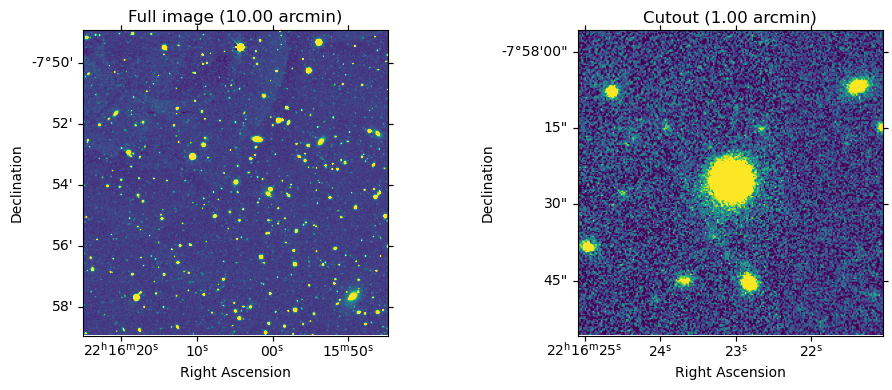

In [7]:
# plot image and cutout
fig = plt.figure(figsize=(10, 4))

ax0 = plt.subplot(121, projection=wcs)
ax0.imshow(hdu.data, origin='lower', norm=norm, aspect='equal')
ax0.set_title(f'Full image ({image_size_arcmin:.2f} arcmin)')
ax0.set_xlabel('Right Ascension')
ax0.set_ylabel('Declination')

ax = plt.subplot(122, projection=wcs)
ax.imshow(cutout.data, origin='lower', norm=norm, aspect='equal')
ax.set_title(f'Cutout ({cutout_size:.2f})')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.tight_layout()

In [8]:
# save files

base_name = f"{objectname}-{survey}-{band}band" # meaningful name from cell 2 info

# rename legacystamps*.fits file to meaningful name
full_hdu = fits.PrimaryHDU(hdu.data, header=wcs.to_header())
full_hdu.writeto(f"{base_name}.fits", overwrite=True)

# save cutout
cutout_hdu = fits.PrimaryHDU(cutout.data, header=cutout.wcs.to_header())
cutout_hdu.writeto(f"{base_name}-cutout.fits", overwrite=True)

# optional: delete legacystamps_*.fits file - toggle in cell 2
if delete_legacystamps_copy.upper() == 'Y':
    if os.path.exists(filename):
        os.remove(filename)